In [1]:
import os
import pandas as pd
import regex as re
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost

In [2]:
path_o = str(os.getcwd()).split("\\")
path_o = "\\".join(path_o[:-1])

In [39]:
os.chdir(path_o+"\\data\\processed")
df = pd.read_csv("data_processed.csv", index_col=0)
df.head()

,budget,genres,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,crew,cast,keywords,month,day,market_share_genres,people_vaccinated,people_fully_vaccinated,total_boosters,New_cases,New_deaths
0,7.405126e+07,0,11.773,1724,70,7.441348e+08,137.0,36,790,313,147,5,29,0.141761,0.0,0.0,0.0,0.0,0.0
1,2.962050e+07,1,13.786,1071,70,3.850665e+07,144.0,19,280,434,504,1,1,0.080776,0.0,0.0,0.0,0.0,0.0
2,2.221538e+07,1,25.768,45,70,1.406953e+08,95.0,19,2304,887,796,4,23,0.080776,0.0,0.0,0.0,0.0,0.0
3,7.405126e+07,1,7.547,1837,69,1.110769e+07,125.0,27,247,1843,681,10,29,0.080776,0.0,0.0,0.0,0.0,0.0
4,1.110769e+08,1,8.597,406,70,2.337024e+08,139.0,19,174,591,104,12,14,0.080776,0.0,0.0,0.0,0.0,0.0


In [40]:
def transform(df):
    df_month_promedio_r = df.groupby("month").mean().reset_index()[["month", "revenue"]]
    df_month_promedio_r.rename(columns={"revenue":"promedio_revenue_month"}, inplace=True)
    df = df.merge(df_month_promedio_r, on="month", how="left")

    df_cast_promedio_r = df.groupby("cast").mean().reset_index()[["cast", "revenue"]]
    df_cast_promedio_r.rename(columns={"revenue":"promedio_revenue_cast"}, inplace=True)
    df = df.merge(df_cast_promedio_r, on="cast", how="left")

    df_director_promedio_r = df.groupby("crew").mean().reset_index()[["crew", "revenue"]]
    df_director_promedio_r.rename(columns={"revenue":"promedio_revenue_crew"}, inplace=True)
    df = df.merge(df_director_promedio_r, on="crew", how="left")

    df_companie_promedio_r = df.groupby("production_companies").mean().reset_index()[["production_companies", "revenue"]]
    df_companie_promedio_r.rename(columns={"revenue":"promedio_revenue_production_companies"}, inplace=True)
    df = df.merge(df_companie_promedio_r, on="production_companies", how="left")
    return df

In [41]:
df = transform(df)
df.head()

,budget,genres,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,crew,cast,keywords,month,day,market_share_genres,people_vaccinated,people_fully_vaccinated,total_boosters,New_cases,New_deaths,promedio_revenue_month,promedio_revenue_cast,promedio_revenue_crew,promedio_revenue_production_companies
0,7.405126e+07,0,11.773,1724,70,7.441348e+08,137.0,36,790,313,147,5,29,0.141761,0.0,0.0,0.0,0.0,0.0,2.039663e+08,2.816103e+08,7.441348e+08,7.441348e+08
1,2.962050e+07,1,13.786,1071,70,3.850665e+07,144.0,19,280,434,504,1,1,0.080776,0.0,0.0,0.0,0.0,0.0,7.505108e+07,1.592010e+08,3.850665e+07,3.850665e+07
2,2.221538e+07,1,25.768,45,70,1.406953e+08,95.0,19,2304,887,796,4,23,0.080776,0.0,0.0,0.0,0.0,0.0,1.069728e+08,7.462467e+07,1.406953e+08,9.835579e+07
3,7.405126e+07,1,7.547,1837,69,1.110769e+07,125.0,27,247,1843,681,10,29,0.080776,0.0,0.0,0.0,0.0,0.0,8.724242e+07,1.110769e+07,1.110769e+07,1.110769e+07
4,1.110769e+08,1,8.597,406,70,2.337024e+08,139.0,19,174,591,104,12,14,0.080776,0.0,0.0,0.0,0.0,0.0,1.825654e+08,3.371241e+08,2.337024e+08,2.337024e+08


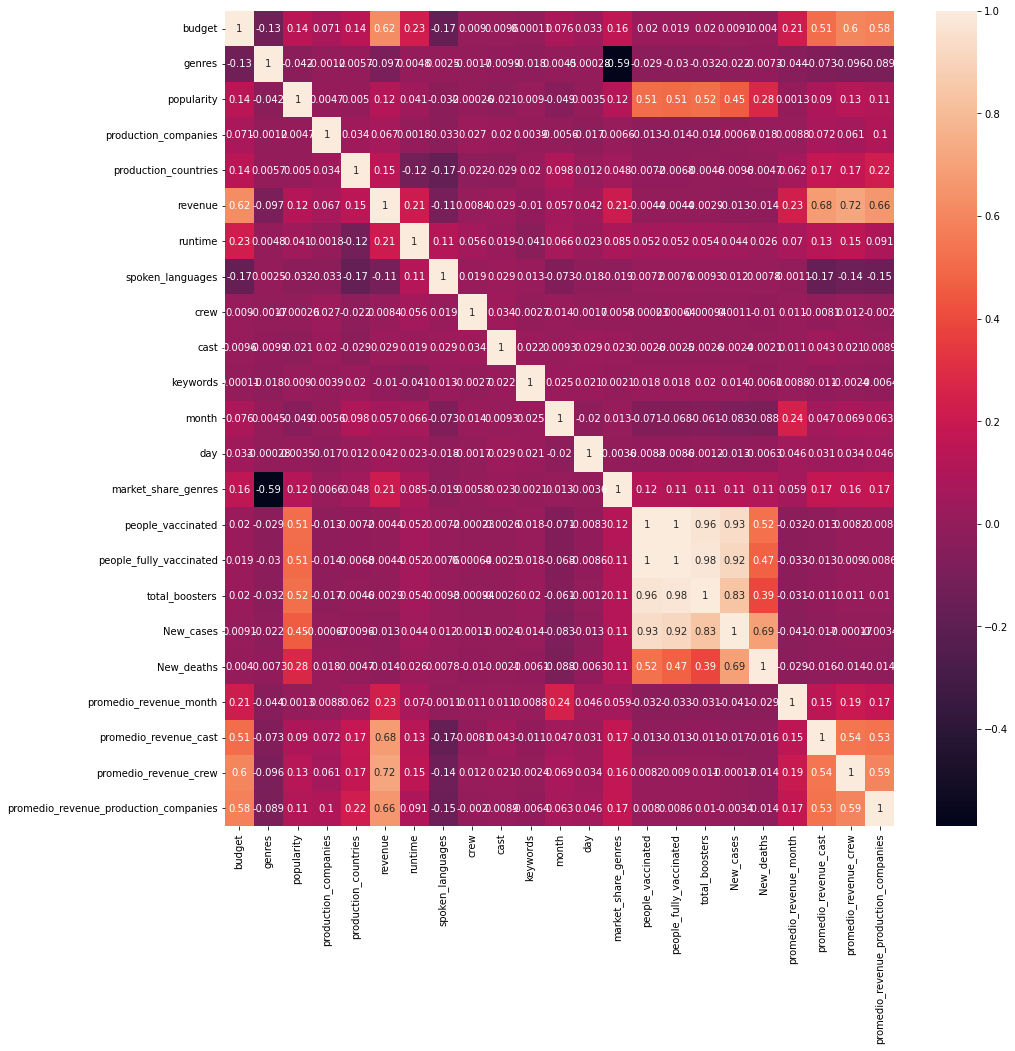

In [149]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True);

In [42]:
df["revenue"] = np.log(df["revenue"])

In [43]:
X = df.drop("revenue", 1).copy()
y = df["revenue"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)


X_train (3738, 22)
X_test (1602, 22)
y_train (3738,)
y_test (1602,)


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
import optuna

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [45]:
def objective(trial, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dvalid = xgboost.DMatrix(X_val, label=y_val)

    param = {
        'objective' : 'reg:squarederror',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 5.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 5.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001,0.01,0.05,0.1,0.2,0.25,0.3]),
        'n_estimators': trial.suggest_categorical('n_estimators', [300,400,500,1000,1500,2000,2500,3000]),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }


    model = xgboost.XGBRegressor(**param)    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)   
    preds = model.predict(X_val)
    rmse = mean_absolute_error(y_val, preds)

    return rmse

In [46]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

params = []

for key, value in trial.params.items():
    params.append(value)
    print("    {}: {}".format(key, value))

[I 2022-04-18 00:25:59,031] A new study created in memory with name: no-name-ab291e7c-3346-4ed3-a862-609282ef9f59
[I 2022-04-18 00:25:59,443] Trial 0 finished with value: 0.5341206352411472 and parameters: {'lambda': 0.0011135310681256864, 'alpha': 0.00602650225518035, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.05, 'n_estimators': 400, 'max_depth': 4, 'min_child_weight': 96}. Best is trial 0 with value: 0.5341206352411472.
[I 2022-04-18 00:26:02,269] Trial 1 finished with value: 1.5066257390076123 and parameters: {'lambda': 0.1981888560204105, 'alpha': 0.06586890763797691, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 2500, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 0 with value: 0.5341206352411472.
[I 2022-04-18 00:26:02,522] Trial 2 finished with value: 0.5641389420195448 and parameters: {'lambda': 0.40159150918824077, 'alpha': 0.0012242185061254597, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.2, 'n

Number of finished trials:  100
Best trial:
  Value: 0.4358335298739079
  Params: 
    lambda: 0.03067985609310814
    alpha: 0.8590342757761328
    colsample_bytree: 1.0
    subsample: 0.7
    learning_rate: 0.01
    n_estimators: 3000
    max_depth: 5
    min_child_weight: 4


In [47]:
lambda_opt = params[0]
alpha_opt = params[1]
colsample_bytree_opt = params[2]
subsample_opt = params[3]
learning_rate_opt = params[4]
n_estimators_opt = params[5]
max_depth_opt = params[6]
min_child_weight_opt = params[7]

In [48]:
xgb = xgboost.XGBRegressor(reg_lambda = lambda_opt,
                   alpha = alpha_opt,
                   colsample_bytree = colsample_bytree_opt,
                   subsample_opt = subsample_opt,
                   learning_rate = learning_rate_opt,
                   n_estimators = n_estimators_opt,
                   max_depth = max_depth_opt,
                   min_child_weight = min_child_weight_opt)

In [49]:
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=0)

[00:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "subsample_opt" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(alpha=0.8590342757761328, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.8590343, reg_lambda=0.03067985609310814,
             scale_pos_weight=1, subsample=1, subsample_opt=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
xgb.score(X_test, y_test)

0.9101453074125664

In [51]:
y_pred_xgb = xgb.predict(X_test) 

In [52]:
print('MAE:', mean_absolute_error(np.exp(y_test),np.exp(y_pred_xgb)))

MAE: 50426266.53095501


In [53]:
predictions = xgb.predict(X_test)

print('MAE:', mean_absolute_error(np.exp(y_test), np.exp(predictions)))
print('MAPE:', mean_absolute_percentage_error(np.exp(y_test), np.exp(predictions)))
print('MSE:', mean_squared_error(np.exp(y_test), np.exp(predictions)))
print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions))))

MAE: 50426266.53095501
MAPE: 0.7583553219653462
MSE: 1.7043299404331726e+16
RMSE: 130549988.1437441


In [57]:
print('MAE:', mean_absolute_error(np.exp(y_train), np.exp(xgb.predict(X_train))))
print('MAPE:', mean_absolute_percentage_error(np.exp(y_train), np.exp(xgb.predict(X_train))))
print('MSE:', mean_squared_error(np.exp(y_train), np.exp(xgb.predict(X_train))))
print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_train), np.exp(xgb.predict(X_train)))))

MAE: 41340536.1455558
MAPE: 0.486266295178798
MSE: 1.0091757230310708e+16
RMSE: 100457738.52875003


In [58]:
df_results=pd.DataFrame(np.exp(y_test).values, columns=["y_test"])
df_results["y_pred"] = np.exp(predictions)
df_results["resta"] = np.abs(df_results["y_test"] - df_results["y_pred"])
df_results.head(5)

,y_test,y_pred,resta
0,2.381704e+05,2.182973e+05,1.987306e+04
1,1.116456e+07,1.724664e+07,6.082083e+06
2,3.000000e+06,9.668843e+06,6.668843e+06
3,6.353896e+07,8.259485e+07,1.905589e+07
4,7.589821e+07,5.581020e+07,2.008801e+07


In [59]:
os.chdir(path_o+"\\model")
with open('model_V11', 'wb') as archivo_salida:
    pickle.dump(xgb, archivo_salida)

In [61]:
new_register = {"id": 11,
                "Name_pickle": "model_V11",
                "Model": xgb, 
                "Description":"XGBRegressor Optuna optimization, log",
                 "Score":xgb.score(X_test, y_test),
                 "MAE":mean_absolute_error(np.exp(y_test), np.exp(predictions)),
                 "MAPE":mean_absolute_percentage_error(np.exp(y_test), np.exp(predictions)),
                 "MSE":mean_squared_error(np.exp(y_test), np.exp(predictions)),
                 "RMSE":np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predictions)))}

df_models_results = pd.read_csv("models.csv", index_col=0)
df_models_results = df_models_results.append(new_register, ignore_index=True)
df_models_results

,id,Name_pickle,Model,Description,Score,MAE,MAPE,MSE,RMSE
0,1,model_V1,LinearRegression(n_jobs=-1),"Regresion Lineal, todas variables, scalar",0.317380,1.066576e+08,2301.643886,4.358168e+16,2.087623e+08
1,2,model_V2,LinearRegression(n_jobs=-1),"Regresion Lineal, no variables label, scalar",0.321573,1.045033e+08,1015.764484,4.331397e+16,2.081201e+08
2,3,model_V3,LinearRegression(n_jobs=-1),"Regresion Lineal, no variables label, log y sc...",0.540263,9.017102e+07,126.927164,8.128038e+16,2.850971e+08
3,4,model_V4,"ElasticNet(alpha=0.03727593720314938, l1_ratio...","Regresion Lineal, Regularizacion (Lasso, Ridge...",0.546992,8.217304e+07,126.894813,5.307954e+16,2.303900e+08
4,5,model_V5,LinearRegression(n_jobs=-1),"Regresion polinomial degree 2, solo variables ...",0.500419,1.013636e+08,99.799883,4.086116e+17,6.392274e+08
5,6,model_V6,"DecisionTreeRegressor(max_depth=6, min_samples...","Decision Arbol Regresion, RandomSearch, log y ...",0.471791,7.878713e+07,92.183933,3.638590e+16,1.907509e+08
6,7,model_V7,"RandomForestRegressor(max_depth=19, max_leaf_n...","Random Forest Regression, RandomSearch, log y ...",0.506937,7.625989e+07,75.122491,3.602874e+16,1.898124e+08
7,8,model_V8,"SVR(C=3, epsilon=0.42)","SVR, RandomSearch, log y scalar",0.540656,7.274343e+07,44.658364,3.095537e+16,1.759414e+08
8,9,model_V9,"RandomForestRegressor(max_depth=14, max_leaf_n...","Random Forest Regressor Pipe, RandomSearch, lo...",0.900384,5.371629e+07,0.862982,2.016932e+16,1.420187e+08
9,10,model_V10,"XGBRegressor(base_score=0.5, booster='gbtree',...","XGBRegressor Pipe, RandomSearch, log y scalar",0.912352,5.140759e+07,0.655321,2.014459e+16,1.419316e+08


In [62]:
df_models_results.to_csv("models.csv")

In [65]:
xgb.feature_importances_

array([0.02535518, 0.01021845, 0.04081899, 0.00410387, 0.00496365,
       0.00804973, 0.0029291 , 0.00519292, 0.00505617, 0.00771633,
       0.00467801, 0.0044831 , 0.00761937, 0.        , 0.        ,
       0.        , 0.00140845, 0.00176965, 0.00905023, 0.13731031,
       0.6475657 , 0.07171075], dtype=float32)

In [68]:
len(X_train.columns)

22

In [71]:
fi_df = pd.DataFrame(xgb.feature_importances_,
                        X_train.columns,
                        columns=['feature_importance']).sort_values('feature_importance', ascending=False).reset_index()
fi_df

,index,feature_importance
0,promedio_revenue_crew,0.647566
1,promedio_revenue_cast,0.137310
2,promedio_revenue_production_companies,0.071711
3,popularity,0.040819
4,budget,0.025355
5,genres,0.010218
6,promedio_revenue_month,0.009050
7,runtime,0.008050
8,keywords,0.007716
9,market_share_genres,0.007619


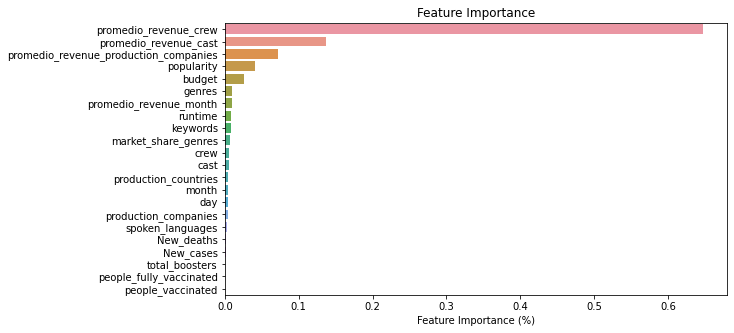

In [74]:
plt.figure(figsize=(9,5))
sns.barplot(x='feature_importance', y='index', data=fi_df)
plt.title('Feature Importance')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')
plt.show()